###  https://github.com/jonbruner/tensorflow-basics/blob/master/save-load/save.ipynb

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

## PUT MODELS IN DIFFERENT FILES AND SAVE THEM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
from random import randint


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
train_digits, train_labels = mnist.train.images[:], mnist.train.labels[:]
test_digits, test_labels = mnist.test.images[:], mnist.test.labels[:]

In [3]:
def add_gaussian_noise(digit, mean, stddev):
    ''' 
    This function adds gaussian noise to the matrix representations
    of the mnist digit
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: the mean of the Gaussian to sample noise from
        (3) float: the standard deviation of the Gaussian to sample
            noise from. Note that the range of pixel values is
            0-255; 
    OUT: 
        (1) np array: noisy training data (n, 784)
    '''
    # #of images (55500 for mnist)
    n_imgs = digit.shape[0]
    # matrix size (784 for mnist)
    n_size = digit.shape[1]
    if stddev == 0:
        noise = np.zeros((n_imgs, n_size))
    else:
        # sample from normal dist
        noise = np.random.normal(mean, stddev/255.,(n_imgs, n_size))
    # add the noise to the data
    x_noisy = digit + noise
    # make sure all data points are in interval [0, 1]
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

noise_stddevs = np.linspace(0, 192, 97)
stddevs = noise_stddevs[::8]

x_noisy_test = np.zeros([len(stddevs), len(test_digits), 784])
for i in range(len(stddevs)):
    x_noisy_test[i] = add_gaussian_noise(test_digits[:], 0, stddevs[i])

In [4]:
def add_blob_occlusion(mnist_digits, occ_perc):
    ''' 
    This function adds occlusions to the matrix representations
    of the mnist digits
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: percentage of occlusion after OReilly [0, 1]
    OUT: 
        (1) np array: occluded training data (n, 784)
        
    From O'REILLY et al. 
    The blob-based occlusion algorithm involved the construction of a 
    filter that was set to 1.0 within a circle of radius 5% of the image size 
    (i.e., 5% of 144 pixels or 7 pixels) and then fell off outside   
    
    '''
    # img is 28x28 pixels
    n = 28
    n_apply = 2.5 * occ_perc * (n / (n/20.00) + 1) + 0.5
    # print "applying " + str(int(n_apply)) + " filters"
    # copy because we are going to modify them.
    occluded_digits = np.copy(mnist_digits)
    counter = 0
    for digit in occluded_digits:
        # plt.imshow(mnist_digits[counter].reshape(n,n), cmap = cm.Greys)
        # plt.show()
        # reshape to size n,n
        occluded_digit = digit.reshape(n,n)
        for i in range(int(n_apply)):
            # randint is inclusive
            # make (2, n-r)
            r = 2 # floor(28/20) = 1.4 # Zeiler 144/20 = 7.2
            a = randint(0,n)
            b = randint(0, n)
            # the coordinates
            y,x = np.ogrid[-a:n-a, -b:n-b]
            # create the circular mask
            mask = x*x + y*y <= r*r
            
            # GAUSSIAN HERE??
            # without gaussian you could potentially create new features.
            
            array = np.zeros((n, n))
            # set all values to -1 (neg numbers clipped later)
            array[mask] = -1
            # add the negative values (1-1 = 0 so the max is occluded as well)
            # could also need a gaussian fall off here
            occluded_digit = occluded_digit+array
            # make it in range 0,1 so negative numbers become 0. 
            occluded_digit = np.clip(occluded_digit, 0., 1.)
        
        # set the occluded digit in the nparray
        occluded_digits[counter] = occluded_digit.reshape(784,)
        counter+=1;
   
    return occluded_digits

In [5]:
occ_percs = np.linspace(0,1,11)
x_occ_test = np.zeros([len(occ_percs), len(test_digits), 784])
for i in range(len(occ_percs)):
    x_occ_test[i] = add_blob_occlusion(test_digits[:], occ_percs[i])

In [6]:
def data_iterator(x, y):
    """ 
    A helper function to create batches for the training data 
    IN: 
        (1) np array: the training images
        (2) np array: the labels [0000010000]
    OUT:
        Batches to train on using iter_.next()
    """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, len(x))
        np.random.shuffle(idxs)
        shuf_features = x[idxs]
        shuf_labels = y[idxs]
        batch_size = 100
        for batch_idx in range(0, len(x), batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size]
            images_batch = images_batch.astype("float32")
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size]
            yield images_batch, labels_batch      

In [7]:
sess = tf.InteractiveSession()

# ONE LAYER

0.7724
0.9205


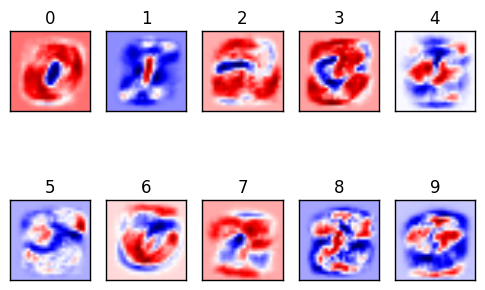

Model saved to ./models/one_layer.ckpt
CPU times: user 3.2 s, sys: 512 ms, total: 3.71 s
Wall time: 2.49 s


In [1249]:
%%time
sess = tf.InteractiveSession()
# ONE LAYER
iter_ = data_iterator(train_digits, train_labels) 


# MODEL HERE 
x = tf.placeholder(tf.float32, [None, 784], name="input")
y_ = tf.placeholder(tf.float32, [None, 10])
# 10 weights to learn
w1 = tf.Variable(tf.zeros([784, 10]))
# 10 biases to learn
b1 = tf.Variable(tf.zeros([10]))    
z1 = tf.matmul(x, w1) + b1
y = tf.nn.softmax(z1, name="output")

init = tf.initialize_all_variables()
sess.run(init)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.initialize_all_variables()
sess.run(init)

for _ in range(1000):
    batch_xs, batch_ys = iter_.next()
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

final = sess.run(accuracy, feed_dict={x:x_noisy , y_: test_labels})
print final    
final = sess.run(accuracy, feed_dict={x:test_digits , y_: test_labels})
print final    

for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(w1)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()
    
saver = tf.train.Saver()
save_path = saver.save(sess, "./models/one_layer.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                   intra_op_parallelism_threads=1))

0.9176


# Naive Bayes

In [25]:
# CREATE THE BAYES PRIORS
classifier_freq = np.ones(10, dtype=int)
pixel_freq = np.ones((28*28,10), dtype=int)

N = train_digits.shape[0]
D = train_digits.shape[1]

for i in range(N):
    c = np.where(train_labels[i] == 1)[0][0]
    classifier_freq[c] = classifier_freq[c] + 1 # = NC
    for j in range(28 * 28 -1):
        if train_digits[i][j] != 0:
            pixel_freq[j,c] = pixel_freq[j,c] + 1 # = NiC

#computing posterior means
theta_hat = np.zeros((28 * 28,10), dtype=float)
for c in range(10):
    for i in range(28*28):
        # we just use the pixel prescence, not intensity
        # 255
        theta_hat[i,c] = (theta_hat[i,c] + pixel_freq[i,c]) / classifier_freq[c]

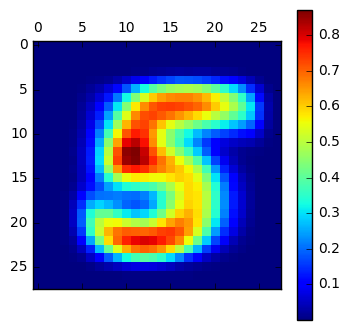

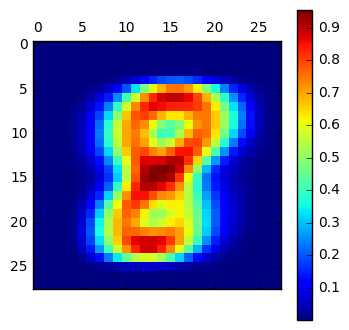

In [51]:
# here are our magnificient priors
plt.matshow(theta_hat[:,5].reshape(28,28))
plt.colorbar()
plt.show()
plt.matshow(theta_hat[:,8].reshape(28,28))
plt.colorbar()
plt.show()

In [115]:
pi_hat = classifier_freq / float(N)
pi_hat_log = np.log(pi_hat)

theta_hat_log = np.log(theta_hat)

print type(theta_hat_log), type(theta_hat_log[0,0])

one_minus_theta_hat_log = np.log(1-theta_hat)

def posterior(pixels, threshold):
    lp = np.zeros(10)
    for c in range(10):
        lp[c] = lp[c] + pi_hat_log[c]
        for j in range (28 * 28):
            if pixels[j] > threshold:
                lp[c] = lp[c] + theta_hat_log[j,c]
            else:
                lp[c] = lp[c] + one_minus_theta_hat_log[j,c]
    return np.exp(lp) / sum(np.exp(lp))

def best_guess(pixels):
    guess = np.argmax(posterior(pixels,0.0))
    prob = posterior(pixels,0)[guess]
    return (guess, prob)

def test_label_guess(index, stddev):
    test = x_occ_test[stddev][index]
    label = np.where(test_labels[index] == 1)[0][0]
    (guess,prob) = best_guess(test)
    return (label,guess,prob)

test_label_guess(3,8)

<type 'numpy.ndarray'> <type 'numpy.float64'>


(0, 7, 0.98927128608221193)

In [117]:
## DOESNT WORK WITH BAYES
# threshold. 
accs = []

for i in range(len(occ_percs)):
    counter = 0
    print occ_percs[i]
    # print x_noisy_test[i]
    for r in range(test_digits.shape[0]):
        (label,guess,prop) = test_label_guess(r, i)
        # if int(label) is not int(guess) and r < 20:
            # print r,i
            # print label,guess
            # plt.matshow(test_digits[r].reshape(28,28))
            # plt.colorbar()
            # plt.show()
        if int(label) == int(guess):
            counter = counter + 1
    
    print (float(counter) / test_digits.shape[0])
    accs.append((occ_percs[i],(float(counter) / test_digits.shape[0])))
    

0.0
0.8413
0.1
0.8202
0.2
0.7964
0.3
0.7679
0.4
0.7443
0.5
0.7027
0.6
0.6571
0.7
0.6148
0.8
0.5781
0.9
0.5386
1.0
0.4986


In [964]:
print accs

0.8413


### theta_hat are the priors now, shape
### 784,10

In [ ]:

'''
# hyperparameters
lr = 0.001
training_iters = 10000
batch_size = 100

n_inputs = 28   # MNIST data input (img shape: 28*28)
n_steps = 28    # time steps
n_hidden_units = 10   # neurons in hidden layer
n_classes = 10      # MNIST classes (0-9 digits)

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name="input")
y_ = tf.placeholder(tf.float32, [None, n_classes])

# Define weights
weights = {
    'in': tf.Variable(tf.random_normal([n_inputs, n_hidden_units])),
    'out': tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
}
biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[n_hidden_units, ])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))
}

def RNN(X, weights, biases):
    # transpose the inputs shape from
    # X ==> (128 batch * 28 steps, 28 inputs)
    X = tf.reshape(X, [-1, n_inputs])

    # into hidden
    # X_in = (128 batch * 28 steps, 128 hidden)
    X_in = tf.matmul(X, weights['in']) + biases['in']
    # X_in ==> (128 batch, 28 steps, 128 hidden)
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])

    # cell
    ##########################################
    cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden_units, forget_bias=0, state_is_tuple=True)
    
    # lstm cell is divided into two parts (c_state, h_state)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)

    # You have 2 options for following step.
    # 1: tf.nn.rnn(cell, inputs);
    # 2: tf.nn.dynamic_rnn(cell, inputs).
    # If use option 1, you have to modified the shape of X_in, go and check out this:
    # https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    # In here, we go for option 2.
    # dynamic_rnn receive Tensor (batch, steps, inputs) or (steps, batch, inputs) as X_in.
    # Make sure the time_major is changed accordingly.
    outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, initial_state=init_state, time_major=False)

    # hidden layer for output as the final results
    #############################################
    # results = tf.matmul(final_state[1], weights['out']) + biases['out']

    # # or
    # unpack to list [(batch, outputs)..] * steps
    outputs = tf.unpack(tf.transpose(outputs, [1, 0, 2]))    # states is the last outputs
    results = tf.add(tf.matmul(outputs[-1], weights['out']), biases['out'],name="output")    # shape = (128, 10)

    return results

# our predictions
y = RNN(x, weights, biases)
# softmax costfunction
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
# trainer
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) '''

# TWO LAYER FEEDBACK

### Two options (BELOW is number 2)

1) just make the feedback layer the same size as x (input) to resolve the size issue. Additionally i see that you compute the fb using z1, it should be z2 since thats the top layer.   
2) Or use the same fb and add it each individual unit of x. so if x is a vector of dimension 784 , use x1+fb,x2+fb .... f784+fb as the value.  

In [8]:
# tf Graph input
# STDDEVS 
# Following He et. al  
# initializing the weights of the l-th layer to a zero-mean Gaussian 
# distribution with standard deviation

# The output z2 should be added to x (input image) and z1 should be calculated from the sum of x and z2

# PREVENTS VANISHING GRADIENT PROBLEM
stddev1=np.sqrt(2 / float(784))
# second = 10 units
stddev2=np.sqrt(2 / float(10))

feedback = True

with tf.Graph().as_default():
    sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                   intra_op_parallelism_threads=1))
    x = tf.placeholder(tf.float32, [None, 784], name="input")
    y_ = tf.placeholder(tf.float32, [None, 10])
        
    w1 = tf.get_variable('w1',[784,10],
                         initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
    b1 = tf.get_variable('b1',[10,],
                         initializer=tf.constant_initializer(0.0))
    # you can change the second one here
    wf = tf.get_variable('wf',[10,10],
                     initializer= tf.random_normal_initializer(mean=0,stddev=stddev2))
    bf = tf.get_variable('bf',[10,],
                        initializer=tf.constant_initializer(0.0))
    w2 = tf.get_variable('w2',[10,10],
                     initializer= tf.random_normal_initializer(mean=0,stddev=stddev2))
    b2 = tf.get_variable('b2',[10,],
                         initializer=tf.constant_initializer(0.0))
    # initial feedback values are just 0
    # we fill it with the size of the placeholder input
    # which is variable (train batches: 100, test batch: 10000)
    val = tf.constant(0, dtype=tf.float32)
    fb = tf.fill(tf.shape(x), val)    
    # fb = tf.get_variable('fb',[100,784],
    #                    initializer=tf.constant_initializer(0.0), dtype=tf.float32)
    
    # z1 = matmul(x+f2,w) + b1. 
    # Here your f2 should be the output of the feedback layer which will be something like 
    # matmul(z2,wf) + bf , where wf are the weights in the feedback layer and bf is the corresponding bias.     
                                        # ? = batchsize
    print 'x' + str(x.get_shape())      # x(?, 784)
    print 'w1' + str(w1.get_shape())    # w1(784, 10)
    
    print 'b1' + str(b1.get_shape())    # b1(10,)
    # tf.concat
    
    if feedback == True:
        z1 =  tf.matmul(tf.add(x,fb), w1)+ b1 # we can't add feedback to x here because its shapes 
    if feedback == False:
        z1 =  tf.matmul(x, w1)+ b1 # we can't add feedback to x here because its shapes 
                                    # are incompatible: x(?,784) and fb(?,10) 
    print 'z1' + str(z1.get_shape())    # z1(?, 10)
    y1 = tf.nn.tanh(z1)                 # or relu
    print 'y1' + str(y1.get_shape())    # y1(?, 10)
    z2 = tf.matmul(y1, w2) + b2
    print 'b2' + str(y1.get_shape())    # b2(?, 10)
    print 'z2' + str(z2.get_shape())    # z2(?, 10)
    # feedback layer
    # bf = 0
    fb = tf.matmul(z2,wf) + bf #+ tf.matmul(z2,wf2) + bf2 + \
         #tf.matmul(z1,wf3) + bf3 # + tf.matmul(z1,wf4) + bf4 + \
         #tf.matmul(z1,wf5) + bf5 + tf.matmul(z1,wf6) + bf6 + \
        #tf.matmul(z1,wf7) + bf7 + tf.matmul(z1,wf8) + bf8 + \
        #tf.matmul(z1,wf9) + bf7 + tf.matmul(z1,wf10) + bf10  
            
    print 'wf' + str(wf.get_shape())    # wf(10, 10) # these are updated
    print 'bf' + str(bf.get_shape())    # bf(10,)    # remains [0000000000]
    print 'fb' + str(fb.get_shape())    # fb(?, 10)  # these are updated 
    # the question: how do we get the feedback in?
    # Z2 HERE FOR TWO LAYER
    y = tf.nn.softmax(z2, name="output")# y(?,10)
    
    tf.add_to_collection('vars', w1)
    tf.add_to_collection('vars', wf)
    tf.add_to_collection('vars', w2)
    
    # FOR Normal
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    # FOR SQUARE
    # cross_entropy = tf.reduce_mean(tf.square(y - y_))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    init = tf.initialize_all_variables()
    sess.run(init)
           
    cost_history = np.empty(shape=[1],dtype=float)
    # 10000
    for i in range(1000):
        batch_xs, batch_ys = iter_.next()
        # if i%201 == 0:
            # print "bla" + str(bla.eval({x: batch_xs})), np.count_nonzero(bla.eval({x: batch_xs}), axis=1)
            # print "fb" + str(fb.eval({x: batch_xs}).shape)
            # print fb.get_shape()
            # print "z2" + str(z2.eval({x: batch_xs}))
            # print "wf" + str(wf.eval())
            # im = wf.eval().flatten()[0::10].reshape((10,-1))
            # plt.imshow(im, clim=(-1.0, 1.0))
            # plt.colorbar()
            # plt.show()
            # print "wf2" + str(wf2.eval())
            # print "wf3" + str(wf3.eval())
            # print "b1" + str(b1.eval())
            # print "b2" + str(b2.eval())
            
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        cost_history = np.append(cost_history,sess.run(cross_entropy,feed_dict={x: batch_xs,y_: batch_ys}))

    plt.plot(range(len(cost_history)),cost_history)
    plt.show()
    final = sess.run(accuracy, feed_dict={x: x_noisy, y_: test_labels})
    print final
    final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels})
    print final
    saver = tf.train.Saver()
    if feedback==True:
        save_path = saver.save(sess, "./models/two_layer_fb.ckpt")
    else:
        save_path = saver.save(sess, "./models/two_layer.ckpt")
        
    print("Model saved to %s" % save_path)

tf.reset_default_graph()
sess = tf.InteractiveSession()

x(?, 784)
w1(784, 10)
b1(10,)
z1(?, 10)
y1(?, 10)
b2(?, 10)
z2(?, 10)
wf(10, 10)
bf(10,)
fb(?, 10)


NameError: name 'iter_' is not defined

# LeCun 28x28->1000->10

## 2-layer NN, 1000 HU (28x28-1000-10) 13.4 secs

<class 'tensorflow.python.framework.ops.Tensor'>
(?, 10)
(?, 784)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
---
(100, 10)
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. 

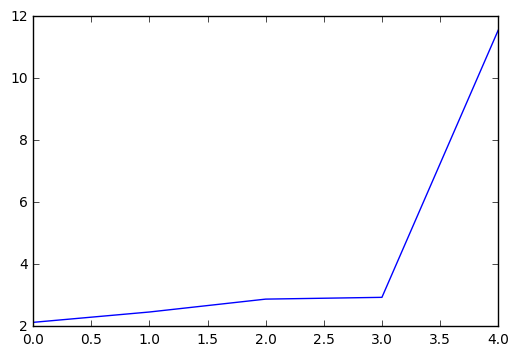

NameError: name 'x_noisy_train_80' is not defined

In [37]:
%%time

tf.reset_default_graph()
sess = tf.InteractiveSession()

stddev1=np.sqrt(2 / float(784))
# second = 10 units
stddev2=np.sqrt(2 / float(10))

iter_ = data_iterator(train_digits, train_labels) 

# MODEL HERE 
skip = False
feedback = True

##
# We now know what happens during each time step in a vanilla RNN. 
# How do we implement this in tensorflow? The length of the input sequence varies 
# for each example. A computational graph defined in tensorflow should run the recurrence 
# operation over each item in the input sequence, one step at a time. It should be able to handle 
# variable length sequences. In other words, it should dynamically unfold the recurrent operation T 
# times for each T lengths of input sequences. This requires a loop in the computational graph. 
# Tensorflow provides scan operation, precisely for this purpose. Let us take a look at tf.scan.


with tf.Graph().as_default():
    sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                   intra_op_parallelism_threads=1))
    x = tf.placeholder(tf.float32, [None, 784], name="input")
    y_ = tf.placeholder(tf.float32, [None, 10])
        
    w1 = tf.get_variable('w1',[784,1000],
                         initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
    b1 = tf.get_variable('b1',[1000,],
                         initializer=tf.constant_initializer(0.0))
    
    print type(fb)
    print fb.get_shape()
    print x.get_shape()
            
    if feedback == True:
        # can't add fb
        z1 =  tf.matmul(x, w1)+ b1 # we can't add feedback to x here because its shapes 
    if feedback == False:
        z1 =  tf.matmul(x, w1)+ b1
    #  z1 = tf.matmul(x, w1) + b1
    y1 = tf.nn.relu(z1)

    w_skip = tf.get_variable('w_skip',[784,10],
                         initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
    b_skip = tf.get_variable('b_skip',[10,],
                         initializer=tf.constant_initializer(0.0))
    
    w_f = tf.get_variable('w_f',[10,10],
                         initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
    b_f = tf.get_variable('b_f',[10,],
                         initializer=tf.constant_initializer(0.0))
   
    w2 = tf.get_variable('w2',[1000,1000],
                         initializer=tf.random_normal_initializer(mean=0, stddev=stddev1))
    b2 = tf.get_variable('b2',[1000,],
                         initializer=tf.constant_initializer(0.0))
    z2 = tf.matmul(y1, w2) + b2
    y2 = tf.nn.relu(z2)

    w3 = tf.Variable(tf.zeros([1000, 10]))
    b3 = tf.Variable(tf.zeros([10]))
    if skip == True:
        z_skip = tf.matmul(x, w_skip) + b_skip
        z3 = tf.matmul(y2, w3) + b3  + z_skip
    else:
        z3 = tf.matmul(y2, w3) + b3 
    
    fb = tf.nn.relu(tf.matmul(z3,w_f) + b_f)

    y = tf.nn.softmax(z3, name="output")

    init = tf.initialize_all_variables()
    sess.run(init)

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    init = tf.initialize_all_variables()
    sess.run(init)
    cost_history=[]
    
    # init initial feedback to zero
    fb_last = np.ones([100,10])
    for i in range(10):
        print fb_last[i]
        if i%5 == 0:
        
            # print(w_skip.eval(sess))
            # print(w_skip.get_shape())
            print("---")
            # print(w_f.eval(sess))
            # print(w_f.get_shape())
           
        batch_xs, batch_ys = iter_.next()
        # print(type(batch_xs))
        print fb_last.shape
        fb_last = fb.eval(feed_dict={x: batch_xs, y_: batch_ys, fb: fb_last})
        print fb_last
        print fb_last.shape
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, fb: fb_last})
        cost_history = np.append(cost_history,sess.run(cross_entropy,feed_dict={x: batch_xs,y_: batch_ys, fb: fb_last}))

    plt.plot(range(len(cost_history)),cost_history)
    plt.show() 
    
    fb_ = np.zeros([len(test_digits), 10])
    final = sess.run(accuracy, feed_dict={x:x_noisy_train_80, y_: train_labels})
    print(final)    
    final = sess.run(accuracy, feed_dict={x:test_digits , y_: test_labels})
    print(final)

    saver = tf.train.Saver()
    if skip == True and feedback == False:
        save_path = saver.save(sess, "./models/lecun_skip.ckpt")
    elif skip == True and feedback == True:
        save_path = saver.save(sess, "./models/lecun_skip_fb.ckpt")
    elif skip == False and feedback == True:
        save_path = saver.save(sess, "./models/lecun_fb.ckpt")   
    else:
        save_path = saver.save(sess, "./models/lecun.ckpt")

    print("Model saved to %s" % save_path)

    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight = sess.run(w_skip)[:,i]
        plt.title(i)
        plt.imshow(weight.reshape([28,28]) , cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    '''
    for i in range(10):
        plt.subplot(2, 5, i+1)
        weight = sess.run(w2)[:,i]
        plt.title(i)
        print(weight.shape)
        plt.imshow(weight.reshape([32,32]), cmap=plt.get_cmap('seismic'))
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
    '''
plt.colorbar()
plt.subplots_adjust(hspace=0.01)
plt.show()
        
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1,
                       intra_op_parallelism_threads=1))




In [1413]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 5
total_series_length = len(train_digits)
truncated_backprop_length = 10
state_size = 784
num_classes = 10
echo_step = 3
batch_size = 100
num_batches = total_series_length//batch_size//truncated_backprop_length


def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)



batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
print(W.get_shape())
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unpack(batchX_placeholder, axis=1)
labels_series = tf.unpack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat(1, [current_input, current_state])  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        
        x,y = iter_.next()
        _current_state = np.zeros((batch_size, state_size))

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            print(start_idx)
            print(end_idx)
            
            print(x.shape,y.shape)
            
            print(y[10:20])
            
            batchX = x[start_idx:end_idx]
            batchY = y[start_idx:end_idx]
            
            print(batchY.shape)
            print(batchX.shape)
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()



(785, 784)


0
10
(100, 784) (100, 10)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]
(10, 10)
(10, 784)


ValueError: Cannot feed value of shape (10, 784) for Tensor u'Placeholder:0', which has shape '(100, 10)'

### RELU 

In [1188]:
%%time
iter_ = data_iterator(train_digits, train_labels)      
# could also change this to 784, 256 ->  256, 256-> 256, 10
# http://stackoverflow.com/questions/41993311/adding-more-layers-to-tensorflow-mnist-tutorial-makes-accuracy-drop                          
# but that would be unfair comparison
# relu init http://cs231n.github.io/neural-networks-2/ -> relu bias 

x = tf.placeholder(tf.float32, [None, 784], name="input")

W = tf.Variable(tf.random_normal([784, 256], stddev=0.1)) 
W1 = tf.Variable(tf.random_normal([256, 256], stddev=0.1))
W2 = tf.Variable(tf.random_normal([256, 10], stddev=0.1))
b = tf.Variable(tf.zeros([256]))
b1 = tf.Variable(tf.zeros([256]))
b2 = tf.Variable(tf.zeros([10]))

y = tf.matmul(x, W) + b
y = tf.nn.relu(y)
y = tf.matmul(y, W1) + b1
y = tf.nn.relu(y)
y = tf.nn.softmax(tf.matmul(y, W2) + b2, name="output")

y_ = tf.placeholder(tf.float32, [None, 10])

init = tf.initialize_all_variables()
sess.run(init)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# use gradient descent just because.
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# evals
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

for _ in range(1000):
    batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


final = sess.run(accuracy, feed_dict={x: x_noisy, y_: test_labels})
print final 
final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels})
print final

saver = tf.train.Saver()
save_path = saver.save(sess, "./models/relu.ckpt")
print("Model saved to %s" % save_path)

tf.reset_default_graph()
sess = tf.InteractiveSession()


0.8019
0.9671
Model saved to ./models/relu.ckpt
CPU times: user 20.2 s, sys: 1.52 s, total: 21.7 s
Wall time: 4.75 s


# SQUARED

In [23]:
%%time

tf.reset_default_graph()
sess = tf.InteractiveSession()

iter_ = data_iterator(train_digits, train_labels)      
# MODEL HERE 
##
x = tf.placeholder(tf.float32, [None, 784], name="input")
# 764 weights to learn
w1 = tf.Variable(tf.zeros([784, 10]))
# 10 biases to learn
b1 = tf.Variable(tf.zeros([10]))    
y = tf.nn.softmax(tf.matmul(x, w1) + b1, name="output")

y_ = tf.placeholder(tf.float32, [None, 10])

init = tf.initialize_all_variables()
sess.run(init)

'''THIS CHANGES FROM THE ONE LAYER MODEL'''
cross_entropy = tf.reduce_mean(tf.square(y - y_))
##
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

for _ in range(1000):
    batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels})
print final

saver = tf.train.Saver()
save_path = saver.save(sess, "./models/one_layer_sqr.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession()

0.8913
Model saved to ./models/one_layer_sqr.ckpt
CPU times: user 2.11 s, sys: 343 ms, total: 2.45 s
Wall time: 1.26 s


## CONVNET

In [ ]:
# tensorflow
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

iter_ = data_iterator(train_digits, train_labels)      

x = tf.placeholder(tf.float32, shape=[None, 784], name="input")
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# decrease ConvNet to 1 layer
# 2 layer apply prior from output to input
# doesnt solve the noise by adding more parameters
# single layer expansion + feedback

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name="output")

init = tf.initialize_all_variables()
sess.run(init)

cross_entropy = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

# train 1000 batches of size 100 (defined in iterator function)
for _ in range(1000):
    batch_xs, batch_ys = iter_.next() 
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
    
# evaluation
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
final = sess.run(accuracy, feed_dict={x: test_digits, y_: test_labels, keep_prob: 1.0})
print final

saver = tf.train.Saver()
save_path = saver.save(sess, "./models/conv.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession()


## Bidirectional rnn

In [372]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name="input")
y_ = tf.placeholder(tf.float32, [None, n_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of foward + backward cells
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [162]:
%%time
# https://github.com/aymericdamien/TensorFlow-Examples
from tensorflow.contrib import rnn
def BiRNN(x, weights, biases):

    # Prepare data shape to match `bidirectional_rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # unstack v1.0.0 so we use unpack
    # Unpack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unpack(x, n_steps, 1)

    # Define lstm cells with tensorflow
    # Forward direction cell
    with tf.variable_scope('forward', reuse=True):
        lstm_fw_cell  = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    with tf.variable_scope('backward', reuse=True):
        lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    try:
        with tf.variable_scope('outputs_2',reuse=None):
            outputs, _, _ = tf.nn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                                  dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        with tf.variable_scope('outputs',reuse=None):    
            outputs = tf.nn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                            dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    # NAME FOR SAVING
    return tf.add(tf.matmul(outputs[-1], weights['out']), biases['out'], name="output")

sess.close()
sess = tf.InteractiveSession()

pred = BiRNN(x, weights, biases)

print type(pred)
print pred


init = tf.initialize_all_variables()
sess.run(init)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.initialize_all_variables()
sess.run(init)

step = 0
while step * batch_size < training_iters:
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Reshape data to get 28 seq of 28 elements
    batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y_: batch_y})
    
    # to check if the training improves
    # if step % display_step == 0:
        # print sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
    step+=1

# calculate accuracy on 256 digits
test_len = 256
# remember to reshape
test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
test_labels = mnist.test.labels[:test_len]

print sess.run(accuracy, feed_dict={x: test_data, y_: test_labels})
saver = tf.train.Saver()
save_path = saver.save(sess, "./models/birnn.ckpt")
print("Model saved to %s" % save_path)
tf.reset_default_graph()
sess = tf.InteractiveSession()

    

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("output:0", shape=(?, 10), dtype=float32)
0.984375
Model saved to ./models/birnn.ckpt
CPU times: user 3min 23s, sys: 20.6 s, total: 3min 44s
Wall time: 48.4 s


In [84]:
mnist.test.images[4:10].reshape((-1, n_steps, n_input)).shape

(6, 28, 28)

In [ ]:
'''MAYBE USEFUL LATER'''
'''
print "validation accuracy:", val_accuracy
y_true = np.argmax(test_label,1)
print "Precision", sk.metrics.precision_score(y_true, y_pred)
print "Recall", sk.metrics.recall_score(y_true, y_pred)
print "f1_score", sk.metrics.f1_score(y_true, y_pred)
print "confusion_matrix"
print sk.metrics.confusion_matrix(y_true, y_pred)
fpr, tpr, tresholds = sk.metrics.roc_curve(y_true, y_pred)
'''